# Interfaz Cerebro-Computadora: Procesamiento

## Importar librerías

In [133]:
#Importar librerías
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from matplotlib import mlab
from importar_dataset import *

In [134]:
# Leer archivo .mat
def leer(ruta):    
    import scipy.io
    return scipy.io.loadmat(ruta, struct_as_record = True)

## Preparar el dataset

5 Usuarios que utilizan como clases brazo izquierdo y derecho:
- BCICIV_calib_ds1b.mat
- BCICIV_calib_ds1c.mat
- BCICIV_calib_ds1d.mat
- BCICIV_calib_ds1e.mat
- BCICIV_calib_ds1g.mat

Se eliminan los usuarios ds1a y ds1f porque utilizan un brazo y un pie como clases

In [135]:
# Cargado el archivo mat
m = leer("BCICIV_1_mat\BCICIV_calib_ds1b.mat")

# Extracción del estudio
EEG = m['cnt'].T
nchannels,nsamples = EEG.shape

# Extracción de los marcadores
event_onsets = m['mrk'][0][0][0]
event_codes = m['mrk'][0][0][1]

# Extracción de la información adicional
sample_rate = m['nfo']['fs'][0][0][0][0]
channel_names = [s[0] for s in m['nfo']['clab'][0][0][0]]
cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
cl1,cl2 = cl_lab[0],cl_lab[1]
nclases = len(cl_lab)

# Etiquetas de inicio de clases
labels = np.zeros((1,nsamples),int)
labels[0,event_onsets] = event_codes

In [136]:
# Despliegue de información obtenida
print('Tamaño de EEG:', EEG.shape)
print('Frecuencia de muestreo:', sample_rate)
print('Número de canales:',nchannels)
print('Nombre de canales:',channel_names)
print('Número de eventos:',event_onsets.shape[1])
print('Códigos de eventos:',np.unique(event_codes))
print('Etiquetas de clases:',cl_lab)
print('Número de clases:',nclases)

Tamaño de EEG: (59, 190594)
Frecuencia de muestreo: 100
Número de canales: 59
Nombre de canales: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Número de eventos: 200
Códigos de eventos: [-1  1]
Etiquetas de clases: ['left', 'right']
Número de clases: 2


## Procesamiento de la señal

### Filtrado CAR

In [137]:
# Función para eliminar referencia promedio común (CAR) de los electrodos
def eliminar_ruido(x):
    CAR = x.mean(axis=1)
    return (x.transpose() - np.array([CAR])).transpose()

# Probando función
EEG = eliminar_ruido(EEG)

### Preparación de los eventos

In [138]:
# Separando los eventos por clases
trials1 = {}

# Preparación de ventana (en número de muestras) de 0.5 - 2.5 segundos
win = np.arange(int(0.5*sample_rate),int(2.5*sample_rate))
nsamples = len(win)

# Loop entre clases
for cl, code in zip(cl_lab,np.unique(event_codes)):

    # Extraer los encendidos de una clase
    cl_onsets = event_onsets[event_codes==code]

    # Ubicar en memoria los eventos
    trials1[cl] = np.zeros((nchannels,nsamples,len(cl_onsets)))

    # Extraer cada evento
    for i, onset in enumerate(cl_onsets):
        trials1[cl][:,:,i] = EEG[:,win+onset]

# Imprimiendo información de los eventos separados por clase (canales x tiempo x evento)
print('Tamaño de evento [cl1]:',trials1[cl1].shape)
print('Tamaño de evento [cl2]:',trials1[cl2].shape)

Tamaño de evento [cl1]: (59, 200, 100)
Tamaño de evento [cl2]: (59, 200, 100)


### Concatenar pruebas

In [139]:
def cargartrial(x):
    m = leer(x)
    EEG = m['cnt'].T
    event_onsets = m['mrk'][0][0][0]
    event_codes = m['mrk'][0][0][1]
    EEG = eliminar_ruido(EEG)

    trials = {}
    for cl, code in zip(cl_lab,np.unique(event_codes)):
        cl_onsets = event_onsets[event_codes==code]
        trials[cl] = np.zeros((nchannels,nsamples,len(cl_onsets)))
        for i, onset in enumerate(cl_onsets):
            trials[cl][:,:,i] = EEG[:,win+onset]
    return trials

In [140]:
# Segunda prueba
trials2 = cargartrial("BCICIV_1_mat\BCICIV_calib_ds1c.mat")
# Tercera prueba
trials3 = cargartrial("BCICIV_1_mat\BCICIV_calib_ds1d.mat")
# Cuarta prueba
trials4 = cargartrial("BCICIV_1_mat\BCICIV_calib_ds1e.mat")
# Quinta prueba
trials5 = cargartrial("BCICIV_1_mat\BCICIV_calib_ds1g.mat")

In [141]:
trials4[cl1].shape

(59, 200, 100)

In [142]:
trials = {}
trials[cl1] = np.dstack((trials1[cl1], trials2[cl1], trials3[cl1], trials4[cl1], trials5[cl1]))
trials[cl2] = np.dstack((trials1[cl2], trials2[cl2], trials3[cl2], trials4[cl2], trials5[cl2]))
trials[cl2].shape

(59, 200, 500)

### Cálculo de la Densidad Spectral de Potencia

In [143]:
def psd(trials):
    '''
    Calcula la PSD de cada trial
    
    Parámetros
    -----------------------------
    trials : Array 3D (canales x muestras x trial)

    Retornos
    ----------------------------
    trial_PSD : Array 3D (canales x PSD x trial)
    freqs : Lista de flotantes
        Frecuencia con la que fue computarizado el trial
    '''

    ntrials = trials.shape[2]
    trials_PSD = np.zeros((nchannels,101,ntrials))

    # Iterar sobre trials y canales
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calcular la PSD
            (PSD,freqs) = mlab.psd(trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)
            trials_PSD[ch,:,trial] = PSD.ravel()
    
    return trials_PSD, freqs

In [144]:
# Aplicando la PSD a las dos clases
psd_1, freqs = psd(trials[cl1])
psd_2, freqs = psd(trials[cl2])
trials_PSD = {cl1: psd_1, cl2: psd_2}

In [145]:
def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
    '''
    Grafica la PSD calculada con (psd).

    Parámetros
    -----------------------
    trials_PSD : Array 3D
        El PSD data
    freqs : Lista de flotantes
        Las frecuencias a las que se definió el PSD
    chan_ind : Lista de enteros
        Indica los canales a graficar
    chan_lab : Lista de cadenas
        (opcional) Lista de los nombres de los canales
    maxy : Flotante
        (opcional) : Límite del eje y
    '''

    plt.figure(figsize=(12,5))

    nchans = len(chan_ind)

    # Máximo 3 gráficas por renglón
    nrows = int(np.ceil(nchans/3))
    ncols = min(3, nchans)

    # Itera sobre los canales
    for i, ch in enumerate(chan_ind):
        # Cuál subplot graficar
        plt.subplot(nrows,ncols,i+1)

        # Graficar el PSD para cada clase
        for cl in trials.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)
        
        # Estilizar la gráfica
        # plt.xlim(1,30)

        if maxy!= None:
            plt.ylim(0,maxy)
        
        plt.grid()
        plt.xlabel('Frecuencia (Hz)')

        if chan_lab is None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])
        
        plt.legend()
    
    plt.tight_layout()

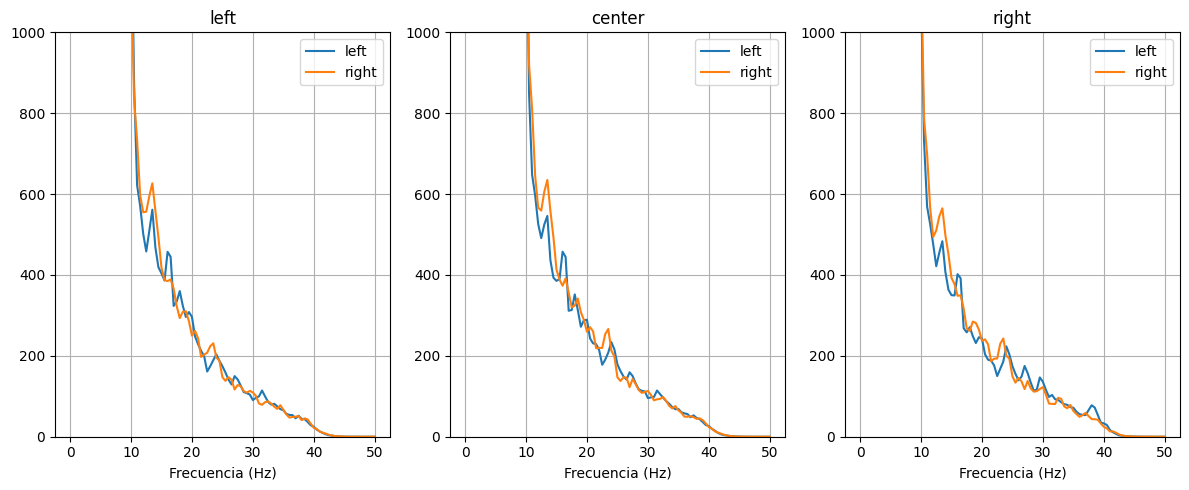

In [146]:
# Probando función plot_psd()

# 1. C3: Central, left
# 2. Cz: Central, central
# 3. C4: Central, right

plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3','Cz','C4']],
    chan_lab=['left','center','right'],
    maxy=1000
)

### Filtrado de la señal

In [147]:
import scipy.signal

def bandpass(trials, lo, hi, sample_rate):
    '''
    Diseña y aplica un filtro pasa banda a la señal

    Parámetros
    -----------------------
    trials : Array 3D (canales x muestras x trial)
        La señal de EEG
    lo : flotante
        Frecuencia de corte uno (Hz)
    hi : flotante
        Frecuencia de corte dos (Hz)
    sample_rate : flotante
        Frecuencia de muestreo (Hz)

    Retorno
    -----------------------
    trials_filt : Array 3D (canales x muestras x trial)
        La señal filtrada        
    '''

    a,b = scipy.signal.iirfilter(6,[lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

    # Aplicando el filtro a cada trial
    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels,nsamples,ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a,b,trials[:,:,i],axis=1)
    return trials_filt

In [148]:
# Probando la función
trials_filt = {cl1: bandpass(trials[cl1], 8, 30, sample_rate),cl2: bandpass(trials[cl2], 8, 30, sample_rate),}

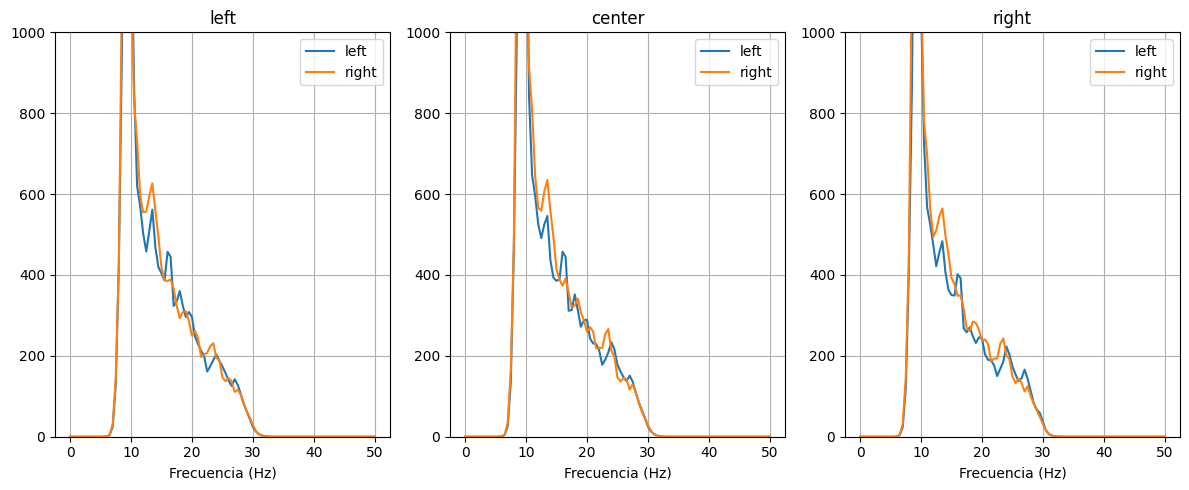

In [149]:
# Aplicando la PSD a las señales filtradas
psd_1, freqs = psd(trials_filt[cl1])
psd_2, freqs = psd(trials_filt[cl2])
trials_PSD = {cl1: psd_1, cl2: psd_2}

plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3','Cz','C4']],
    chan_lab=['left','center','right'],
    maxy=1000
)

### Algoritmo Common Spatial Patterns (CSP)

In [150]:
# Función para calcular el valor logaritmo de cada canal
def logvar(trials):
    '''
    Calcular el valor logaritmo de cada canal

    Parámetros
    ---------------------------
    trials: Array 3D (canales x muestras x trials)
        La señal de EEG.
    
    Retorno
    ---------------------------
    logvar : Array 2D (canales x trials)
        Para cada canal calcula su valor logarítmico
    '''

    return np.log(np.var(trials, axis=1))

In [151]:
# Probando la función
trials_logvar = {cl1: logvar(trials_filt[cl1]), cl2: logvar(trials_filt[cl2])}

In [152]:
# Función para visualizar el logaritmo de cada canal
def plot_logvar(trials,nchannels = nchannels):
    '''
    Graficar el valor logaritmo de cada canal

    Parámetros
    -------------------
    trials : Diccionario que contiene los trials (log-vars x trials) para 2 clases.
    '''

    plt.figure(figsize=(12,5))

    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4

    y0 = np.mean(trials[cl1], axis=1)
    y1 = np.mean(trials[cl2], axis=1)

    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')

    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var de cada canal/componente')
    plt.xlabel('Canales/componentes')
    plt.ylabel('Log-var')
    plt.legend(cl_lab)

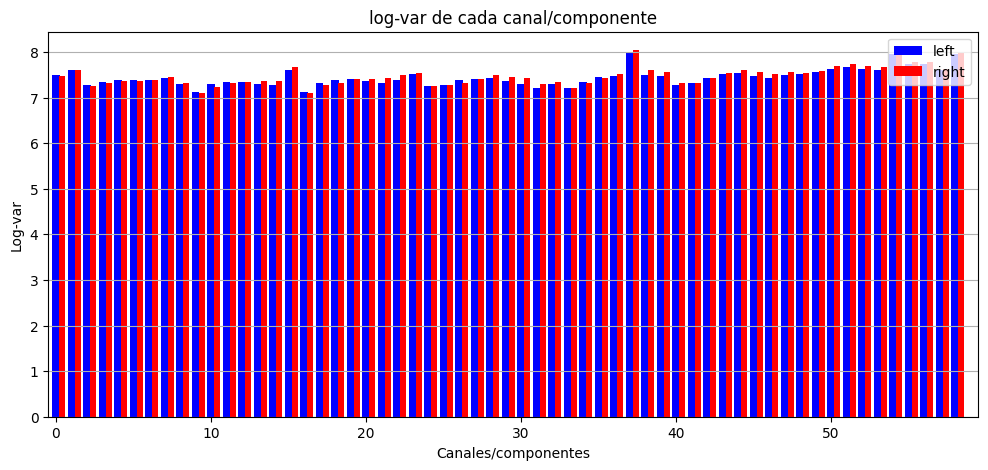

In [153]:
# Probando la función
plot_logvar(trials_logvar)

- Vemos que la mayoría de los canales muestran una pequeña diferencia en el log-var de la señal entre las dos clases.
- El siguiente paso es pasar de 59 canales a sólo unas pocas mezclas de canales.
- El algoritmo CSP calcula mezclas de canales que están diseñadas para maximizar la diferencia de variación entre dos clases.
- Estas mezclas se denominan filtros espaciales.

In [154]:
from scipy import linalg
def cov(trials):
    '''Calcula la covarianza de cada prueba y entrega el promedio'''
    ntrials = trials.shape[2]
    covs = [trials[:,:,i].dot(trials[:,:,i].T) /nsamples for i in range(ntrials)]
    return np.mean(covs, axis=0)

def whitening(sigma):
    '''Calcula el whitering de una matrix de covarianza sigma'''
    U, l, _ = linalg.svd(sigma)
    return U.dot(np.diag(l ** -0.5))

def csp(trials_1, trials_2):
    '''
    Calcula la transformada CSP matriz W.

    Argumentos:
    ------------------
        trials_r : Array (canales x muestras x trials) movimientos derecha
        trials_f : Array (canales x muestras x trials) movimientos izquierda

    Retornos:
    -----------------
        Matriz mezclada W
    '''
    cov_1 = cov(trials_1)
    cov_2 = cov(trials_2)
    P = whitening(cov_1 + cov_2)
    B, _, _ = linalg.svd(P.T.dot(cov_2).dot(P))
    W = P.dot(B)
    return W

def apply_mix(W,trials):
    '''Aplica la matriz mezclada a cada trial (multiplica W con la matriz de señal EEG'''
    ntrials = trials.shape[2]
    trials_csp = np.zeros((nchannels, nsamples,ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
    return trials_csp

In [155]:
# Probando la función
W = csp(trials_filt[cl1], trials_filt[cl2])
trials_csp = {cl1: apply_mix(W, trials_filt[cl1]),cl2: apply_mix(W, trials_filt[cl2])}

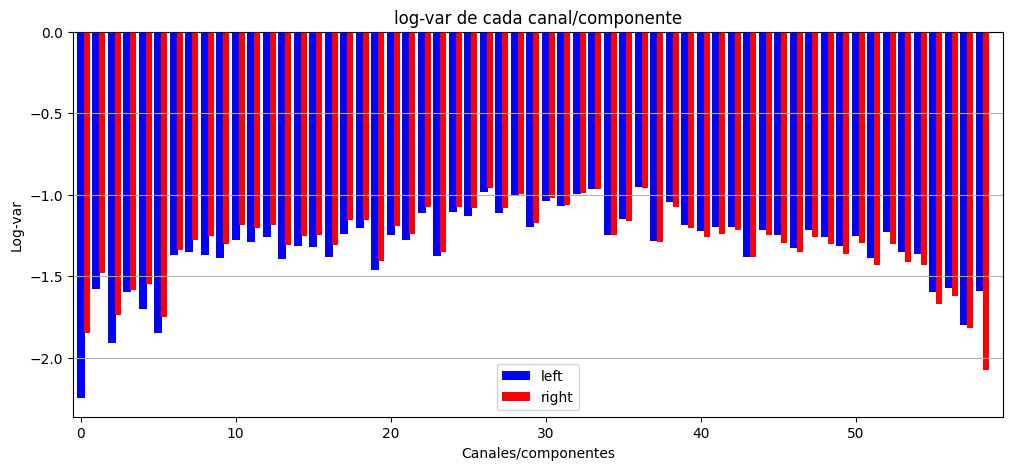

In [156]:
# Graficando log-var una vez aplicado el algoritmo CSP
trials_logvar = {cl1: logvar(trials_csp[cl1]),cl2: logvar(trials_csp[cl2])}
plot_logvar(trials_logvar)

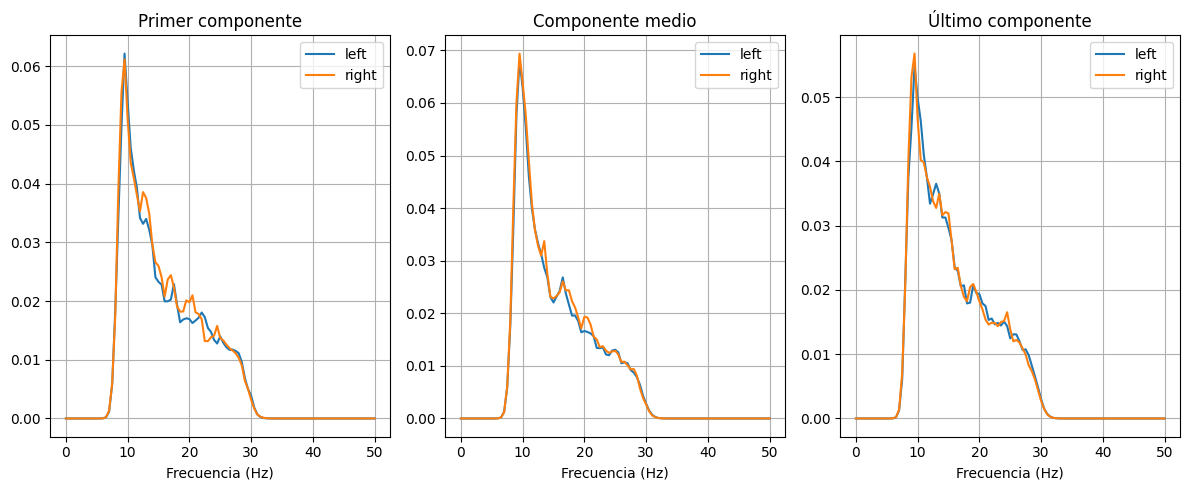

In [157]:
# Graficando PSD del CSP
psd_1, freqs = psd(trials_csp[cl1])
psd_2, freqs = psd(trials_csp[cl2])
trials_PSD = {cl1: psd_1, cl2: psd_2}

plot_psd(trials_PSD, freqs, 
    [channel_names.index(ch) for ch in ['C3','Cz','C4']], chan_lab = ['Primer componente', 'Componente medio', 'Último componente'])

In [158]:
def plot_scatter(one, two):
    plt.figure()
    plt.scatter(one[0,:], one[-1,:], color='b')
    plt.scatter(two[0,:], two[-1,:], color='r')
    plt.xlabel('Último componente')
    plt.ylabel('Primer componente')
    plt.legend(cl_lab)

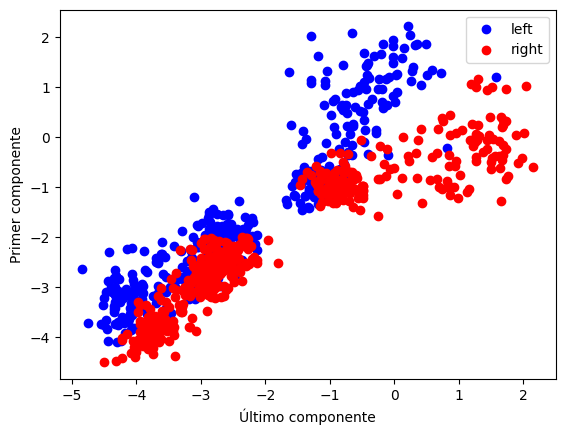

In [159]:
# Probando la función
plot_scatter(trials_logvar[cl1], trials_logvar[cl2])

### Elección de canal de CSP

In [160]:
# Función para encontrar la máxima diferencia entre mezclas
def csp_car(trials_logvar):
    size = trials_logvar[cl1].shape[0]
    vector = np.zeros(size)
    for s in range(size):
        vector[s] = ((np.mean(trials_logvar[cl1][s])-np.mean(trials_logvar[cl2][s]))/-np.mean(trials_logvar[cl2][s]))
    return vector

In [161]:
# Función para encontrar la correlación de Pearson
def csp_corr_pearson(trials_logvar):
    size = trials_logvar[cl1].shape[0]
    vector = np.zeros(size)
    for s in range(size):
        vector[s] = np.corrcoef(trials_logvar[cl1][s],trials_logvar[cl2][s])[0,1]
    return vector

In [162]:
# Probando funciones
csp_vector = csp_car(trials_logvar)
csp_corr = csp_corr_pearson(trials_logvar)
csp_fin = csp_corr * csp_vector

Text(0, 0.5, 'Coeficiente de correlación')

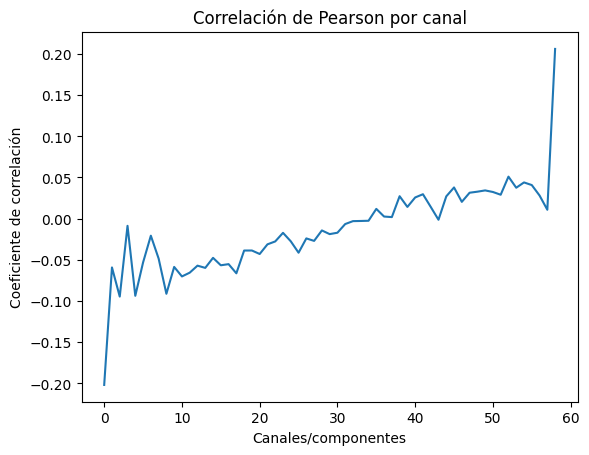

In [163]:
plt.plot(csp_fin)
plt.title('Correlación de Pearson por canal')
plt.xlabel('Canales/componentes')
plt.ylabel('Coeficiente de correlación')

In [132]:
val_cl1 = np.where(csp_fin == np.amin(csp_fin))[0][0]
val_cl2 = np.where(csp_fin == np.amax(csp_fin))[0][0]
print("Se usarán los canales de la posición", val_cl1, "y", val_cl2, "para clasificación")

Se usarán los canales de la posición 0 y 58 para clasificación


## Extracción de características

### Preparación

In [ ]:
# Porcentaje de pruebas para usarse en el entranmiento
train_percentage = 0.7

In [ ]:
# Calcular el número de pruebas por clase por porcentaje elegido
ntrain_1 = int(trials_filt[cl1].shape[2] * train_percentage)
ntrain_2 = int(trials_filt[cl2].shape[2] * train_percentage)

ntest_1 = trials_filt[cl1].shape[2] - ntrain_1
ntest_2 = trials_filt[cl2].shape[2] - ntrain_2

In [ ]:
# Falta función para mezclar data set


In [ ]:
# Seaparando la señal filtrada en entrenamiento y prueba
train = {cl1: trials_filt[cl1][:,:,:ntrain_1],
cl2: trials_filt[cl2][:,:,:ntrain_2]}

test = {cl1: trials_filt[cl1][:,:,ntrain_1:],
cl2: trials_filt[cl2][:,:,ntrain_2:]}

### Extracción de características estadísticas

In [ ]:
# Función de extracción de características
def statistics_feature_extraction(x):
    import math
    import numpy as np

    vector_caracteristicas = []
    xsize = x.shape[0]

    #F1: Promedio
    promedio=x.mean()
    vector_caracteristicas.append(promedio)
    #F2: Promedio absoluto
    vector_caracteristicas.append(abs(vector_caracteristicas[0]))
    #F3: Máximo
    vector_caracteristicas.append(max(x))
    #F4: Máximo absoluto
    vector_caracteristicas.append(abs(vector_caracteristicas[2]))
    # #F5: Mínimo
    vector_caracteristicas.append(min(x))
    #F6: Mínimo absoluto
    vector_caracteristicas.append(abs(vector_caracteristicas[4]))
    #F7: Máximo + Mínimo
    vector_caracteristicas.append(vector_caracteristicas[2]+vector_caracteristicas[4])
    #F8: Máximo - Mínimo
    vector_caracteristicas.append(vector_caracteristicas[2]-vector_caracteristicas[4])

    #F9: ELIMINADA

    #F10: Longitud de curva
    sumita=0
    for i in range(xsize-1):
        sumita=sumita+abs(x[i+1]-x[i])
    vector_caracteristicas.append(sumita)
    #F11: Energía
    sumita=0
    for i in range(xsize):
        sumita=sumita+(x[i]**2)
    vector_caracteristicas.append(sumita/xsize)
    #F12: Energía no lineal promedio (ANE)
    sumita=0
    for i in range(xsize-2):
        sumita=sumita+((x[i+1]**2)-(x[i]*x[i+2]))
    vector_caracteristicas.append(sumita/xsize-2)
    #F13: Entropía espectral (SE)
    sumita=0
    for i in range(xsize):
        pk=(abs(x[i]**2))/(xsize*1.5)
        sumita=sumita+(pk*math.log2(pk))
    vector_caracteristicas.append(sumita)

    #F14: ELIMINADA

    #F15: Integral
    sumita=0
    for i in range(xsize):
        sumita=sumita+abs(x[i])
    vector_caracteristicas.append(sumita)
    #F16: Desviación estándar
    desv=x.std()
    vector_caracteristicas.append(desv)
    #F17: Varianza
    vector_caracteristicas.append(x.var())
    #F18: Oblicuidad
    sumita=0
    for i in range(xsize):
        sumita=sumita+(((x[i]-promedio)/desv)**3)
    vector_caracteristicas.append(sumita/xsize)
    #F19: Curtosis
    sumita=0
    for i in range(xsize):
        sumita=sumita+(((x[i]-promedio)/desv)**4)
    vector_caracteristicas.append(sumita/xsize)
    #F20: Sumatoria
    sumita=0
    for i in range(xsize):
        sumita=sumita+x[i]
    vector_caracteristicas.append(sumita)
    #F21: Mediana
    vector_caracteristicas.append(np.median(x))
    return vector_caracteristicas

In [ ]:
# Extraer características
def stat_ext(x):
    a,b,c = x.shape
    cuantificador = np.zeros([a,19,c])
    for repeticion in range(a):
        for canal in range(c):
            vector = statistics_feature_extraction(x[repeticion,:,canal])
            cuantificador[repeticion,:,canal] = vector
    return cuantificador

In [ ]:
# Almacenando las características estadísticas en sus respectivas llaves de diccionario
train_cuant = {cl1: stat_ext(train[cl1].T),
cl2: stat_ext(train[cl2].T)}

test_cuant = {cl1: stat_ext(test[cl1].T),
cl2: stat_ext(test[cl2].T)}

In [ ]:
print("Cuantificador por clase de tamaño:", train_cuant[cl1].shape)

### Algoritmo de PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def features2pca(signal):  
    pca = PCA(n_components=2)
    pca.fit(signal)
    transformada = pca.transform(signal)
    return transformada

In [ ]:
def channels2pca(x):
    a,b,c = x.shape
    cuant = np.zeros([a,2,c])
    for i in range(c):
        cuant[:,:,i] = features2pca(x[:,:,i])
    return cuant

In [ ]:
# Aplicando PCA a los cuantificadores
pca_train_cuant = {cl1: channels2pca(train_cuant[cl1]),
cl2: channels2pca(train_cuant[cl2])}

pca_test_cuant = {cl1: channels2pca(test_cuant[cl1]),
cl2: channels2pca(test_cuant[cl1])}

In [ ]:
print("Cuantificador PCA por clase de tamaño:", pca_train_cuant[cl1].shape)

### Extracción de características por CSP

In [ ]:
# Entrenar el CSP únicamente con el set de entrenamiento
W = csp(train[cl1], train[cl2])

In [ ]:
# Creando clases de pruebas para CSP
csp_train = {cl1: apply_mix(W, train[cl1]),
cl2: apply_mix(W, train[cl2])}

csp_test = {cl1: apply_mix(W, test[cl1]),
cl2: apply_mix(W, test[cl2])}

In [ ]:
# Función para encontrar la máxima diferencia entre mezclas
def csp_car(trials_logvar):
    size = trials_logvar[cl1].shape[0]
    vector = np.zeros(size)
    for s in range(size):
        vector[s] = ((np.mean(trials_logvar[cl1][s])-np.mean(trials_logvar[cl2][s]))/-np.mean(trials_logvar[cl2][s]))
    return vector

In [ ]:
# Probando función
csp_vector = csp_car(trials_logvar)

val_cl1 = np.where(csp_vector == np.amin(csp_vector))[0][0]
val_cl2 = np.where(csp_vector == np.amax(csp_vector))[0][0]
print("Se usarán los canales de la posición", val_cl1, "y", val_cl2, "para clasificación")

In [ ]:
csp_vector

In [ ]:
comp = np.array([val_cl1,val_cl2])

ftrain = {cl1:[],cl2:[]}
ftrain[cl1] = csp_train[cl1][comp,:,:]
ftrain[cl2] = csp_train[cl2][comp,:,:]
ftest = {cl1:[],cl2:[]}
ftest[cl1] = csp_test[cl1][comp,:,:]
ftest[cl2] = csp_test[cl2][comp,:,:]

In [ ]:
ftrain[cl1].shape

In [ ]:
ftest[cl1].shape

In [ ]:
csp_train[cl1] = logvar(ftrain[cl1])
csp_train[cl2] = logvar(ftrain[cl2])
csp_test[cl1] = logvar(ftest[cl1])
csp_test[cl2] = logvar(ftest[cl2])

In [ ]:
csp_train[cl2].shape

In [ ]:
# Concatenando clases
csp_x_train = np.concatenate([csp_train[cl1].T, csp_train[cl2].T])
csp_x_test = np.concatenate([csp_test[cl1].T, csp_test[cl2].T])

csp_x_train.shape

In [ ]:
ntest_1

In [ ]:
# Creando vector de etiquetas
csp_y_train = np.concatenate([np.zeros(ntrain_1), np.ones(ntrain_2)])
csp_y_test = np.concatenate([np.zeros(ntest_1), np.ones(ntest_2)])

In [ ]:
# Convertir el array de salidas a una codificación one_ hot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
# Cambiamos el y_train a una forma (numero de datos, etiqueta categorica)
csp_y_train = csp_y_train.reshape(len(csp_y_train), 1)
# Y cambiamos a un vector one-hot
csp_y_train_onehot = onehot_encoder.fit_transform(csp_y_train)

# # Cambiamos el y_test a una forma (numero de datos, etiqueta categorica)
csp_y_test = csp_y_test.reshape(len(csp_y_test), 1)
# Y cambiamos a un vector one-hot
csp_y_test_onehot = onehot_encoder.fit_transform(csp_y_test)

csp_y_train_onehot.shape

## Clasificación

### Por Red Neuronal Densa (DNN)

#### Declaración de arquitectura

In [ ]:
model_vanilla = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=(2,), activation= 'relu'),
    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.Dense(2, activation = 'softmax')
])

In [ ]:
# Graficar la arquitectura de la red
modelo = model_vanilla.summary()

#### Entrenamiento

In [ ]:
model_vanilla.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_vanilla.fit(csp_x_train, y=csp_y_train_onehot, epochs=100, shuffle=True)

In [ ]:
train_loss, train_acc = model_vanilla.evaluate(csp_x_train, csp_y_train_onehot, verbose=2)

print('\nExactitud en el entrenamiento:', train_acc, '\nPérdida en el entrenamiento:', train_loss, )

#### Validación

In [ ]:
test_loss, test_acc = model_vanilla.evaluate(csp_x_test,  csp_y_test_onehot, verbose=2)

print('\nExactitud en la prueba:', test_acc, '\nPérdida en la prueba:', test_loss,)

In [ ]:
predictions = model_vanilla.predict(csp_x_test)
predictions2 = np.array([np.argmax(c) for p,c in enumerate(predictions)])

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(csp_y_test, predictions2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()

plt.show()

### Por Cuantificación Vectorial

Está en proceso...

### Por Red Neuronal Convolucional (CNN)

In [ ]:
x_train = np.concatenate([train[cl1].T , train[cl2].T])
x_test = np.concatenate([test[cl1].T, test[cl2].T])

x_test.shape

In [ ]:
from sklearn.preprocessing import StandardScaler

def estandarizar(señal):
    neo = np.ones((señal.T.shape))
    for ch in range(señal.shape[2]):
        scaler = StandardScaler()
        model = scaler.fit(señal.T[ch])
        scaled_data = model.transform(señal.T[ch])
        neo[ch] = scaled_data
    return neo.T

In [ ]:
x_train = estandarizar(x_train)
x_test = estandarizar(x_test)

In [ ]:
y_train = np.concatenate([np.zeros(ntrain_1), np.ones(ntrain_2)])
y_test = np.concatenate([np.zeros(ntest_1), np.ones(ntest_2)])
y_train.shape

In [ ]:
model_cnn = tf.keras.Sequential()

model_cnn.add(tf.keras.layers.Conv1D(8, (3), activation='tanh', input_shape=(200, 59) , padding='same'))
model_cnn.add(tf.keras.layers.MaxPooling1D((2)))
model_cnn.add(tf.keras.layers.Conv1D(16, (3), activation='tanh', padding= 'same'))
model_cnn.add(tf.keras.layers.MaxPooling1D((2)))
model_cnn.add(tf.keras.layers.Conv1D(16, (3), activation='relu', padding= 'same'))
model_cnn.add(tf.keras.layers.MaxPooling1D((2)))


model_cnn.add(tf.keras.layers.Flatten())
model_cnn.add(tf.keras.layers.Dense(32, activation= 'relu'))
# model_cnn.add(tf.keras.layers.Dense(16, activation= 'relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model_cnn.compile(optimizer='adam',
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model_cnn.fit(x_train, y_train, batch_size=8, shuffle=True, epochs=30,validation_data=(x_test, y_test))

In [ ]:
# Graficar la arquitectura de la red
modelo = model_cnn.summary()

In [ ]:
predictions = model_cnn.predict(x_test)
predictions2 = np.array([np.argmax(c) for p,c in enumerate(predictions)])

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

cm = confusion_matrix(y_test, predictions2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()

plt.show()

### Por Máquinas de Soporte Vectorial (SVM)

In [ ]:
x_train = np.concatenate([csp_train[cl1].T , csp_train[cl2].T])
x_test = np.concatenate([csp_test[cl1].T, csp_test[cl2].T])

x_test.shape

In [ ]:
y_train = np.concatenate([np.zeros(ntrain_1), np.ones(ntrain_2)])
y_test = np.concatenate([np.zeros(ntest_1), np.ones(ntest_2)])
y_train.shape

In [ ]:
from sklearn import svm
modelo = svm.SVC(kernel='linear')

In [ ]:
modelo.fit(x_train,y_train)

In [ ]:
def svm_plot_scatter(one, two):
    plt.figure()
    plt.scatter(one[0,:], one[-1,:], color='b')
    plt.scatter(two[0,:], two[-1,:], color='r')
    plt.xlabel('Último componente')
    plt.ylabel('Primer componente')
    plt.legend(cl_lab)

# Constructing a hyperplane using a formula.
    w = modelo.coef_[0]           # w consists of 2 elements
    b = modelo.intercept_[0]      # b consists of 1 element


    x_points = np.linspace(-3, 1)    # generating x-points from -1 to 1
    y_points = -(w[0] / w[1]) * x_points - b / w[1]  # getting corresponding y-points

    # Plotting a red hyperplane
    plt.plot(x_points, y_points, c='k');

In [ ]:
svm_plot_scatter(trials_logvar[cl1], trials_logvar[cl2])

In [ ]:
yf= modelo.predict(x_test)
print("Primera predicción: ",yf)
print("Datos reales: ",y_test)

In [ ]:
# Evaluar del modelo con puntaje F1
from sklearn.metrics import f1_score

In [ ]:
print("Puntaje F1, clase 1: %.4f" % f1_score(y_test, yf, pos_label=0))

In [ ]:
print("Puntaje F1, clase 2: %.4f" % f1_score(y_test, yf, pos_label=1))

In [ ]:
# Evaluación del modelo con Índice de Jaccard
from sklearn.metrics import jaccard_score

In [ ]:
# Puntaje de la clase 1
jaccard_score(y_test, yf, pos_label=0)
print("Índice de Jaccard para clase 1: %.4f" % jaccard_score(y_test, yf, pos_label=0))

In [ ]:
# Puntaje de la clase 2
jaccard_score(y_test, yf, pos_label=1)
print("Índice de Jaccard para clase 2: %.4f" % jaccard_score(y_test, yf, pos_label=1))

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

cm = confusion_matrix(y_test, yf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()

plt.show()

### Por Linear Discriminant Analysis (LDA)

In [ ]:
def train_lda(class1, class2):
    '''
    Entrena al algoritmo LDA
    argumentos:
        class1 - Array (repeticiones x características) para clase 1
        class2 - Array (repeticiones x características) para clase 2
    retornos:
        Proyección de la matriz W
        Offset b        
    '''
    nclasses = 2

    nclass1 = class1.shape[0]
    nclass2 = class2.shape[0]

    # Class previas: En este caso, tenemos una igual cantidad de repeticiones de cada clase, así que ambos son de 0.5
    prior1 = nclass1 / float(nclass1 + nclass2)
    prior2 = nclass2 / float(nclass1 + nclass2)
    
    mean1 = np.mean(class1, axis=0)
    mean2 = np.mean(class2, axis=0)

    class1_centered = class1 - mean1
    class2_centered = class2 - mean2

    # Calcular la covarianza entre las características
    cov1 = class1_centered.T.dot(class1_centered) / (nclass1 - nclasses)
    cov2 = class2_centered.T.dot(class2_centered) / (nclass2 - nclasses)

    W = (mean2-mean1).dot(np.linalg.pinv(prior1*cov1 + prior2*cov2))
    b = (prior1*mean1 + prior2*mean2).dot(W)

    return(W,b)

In [ ]:
def apply_lda(test, W, b):
    '''
    Aplica previamente entrenado LDA a nuevos datos.
    argumentos:
        test - Array (características x repeticiones) que contenga los datos
        W - La proyección de la matriz W
        b - Offset b
    retornos:
        Lista de etiquetas de clase para cada prueba
    '''
    ntrials = test.shape[1]

    prediction = []
    for i in range(ntrials):
        # Generalización de:
        # Salida = W[0] * test[0,1] + W[1] * test[1,i] - b
        result = W.dot(test[:,i]) - b
        if result <= 0:
            prediction.append(1)
        else:
            prediction.append(2)

    return np.array(prediction)

In [ ]:
W,b = train_lda(csp_train[cl1].T, csp_train[cl2].T)

print('W:',W)
print('b:',b)

In [ ]:
plot_scatter(csp_train[cl1], csp_train[cl2])

In [ ]:
# Calculando la frontera de decisión (x,y)
x = np.arange(-5,1,0.1)
y = (b - W[0]*x) / W[1]

In [ ]:
# Graficando la frontera de decisión
plot_scatter(csp_train[cl1], csp_train[cl2])
plt.plot(x,y, linestyle = '--', linewidth = 2, color = 'k')
plt.xlim(-5,1)
plt.ylim(-2.2,1)

In [ ]:
# Graficando la frontera de decisión
plot_scatter(csp_test[cl1], csp_test[cl2])
plt.plot(x,y, linestyle = '--', linewidth = 2, color = 'k')
plt.xlim(-5,1)
plt.ylim(-2.2,1)

In [ ]:
# Matriz de confusión entrenamiento
conf = np.array([
    [(apply_lda(csp_train[cl1], W, b) == 1).sum(), (apply_lda(csp_train[cl2], W, b) == 1).sum()],
    [(apply_lda(csp_train[cl1], W, b) == 2).sum(), (apply_lda(csp_train[cl2], W, b) == 2).sum()],
])

print('Matriz de confusión:')
print(conf)
print('Exactitud:', (np.sum(np.diag(conf)) / float(np.sum(conf))))

In [ ]:
# Matriz de confusión prueba
conf = np.array([
    [(apply_lda(csp_test[cl1], W, b) == 1).sum(), (apply_lda(csp_test[cl2], W, b) == 1).sum()],
    [(apply_lda(csp_test[cl1], W, b) == 2).sum(), (apply_lda(csp_test[cl2], W, b) == 2).sum()],
])

print('Matriz de confusión:')
print(conf)
print('Exactitud:', (np.sum(np.diag(conf)) / float(np.sum(conf))))

- Revisar la programación para las CNN
- SVM diferentes Kernel (Polinomial grado 3, Gaussiano, Gaussiano Radial)
- F1 score, exactitud, recall para todos los clasificadores
- Revisar en qué revista se publicaron los artículos
- Artículo de 4 a 6 hojas 
- Presentación con resultados de clasificación intra e interusuario